El algoritmo del PCA requiere de unos 256 componentes para capcturar el 80% de la variabilidad. La hipotesis es que es posible mejorar esto si mediante un filtrado de fourier separamos el background, algo relacionado a altas o bajas frecuencias.

In [1]:
import json
import pickle

# # Cargar el IPCA desde un archivo pickle
# with open('ipca_model.pkl', 'rb') as f:
#     loaded_ipca = pickle.load(f)

# Cargar el archivo JSON
with open('statistics.json', 'r') as file:
    data = json.load(file)

# Extraer las variables
mean = data['mean']
std = data['std']

# Imprimir las variables
print("Mean:", mean)
print("Standard Deviation:", std)


Mean: 0.0004291016057409468
Standard Deviation: 1.2136419578062354e-06


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from grav_lens import get_datasets

In [3]:
batch_size = 32
home_data = os.path.join("..","data")

train_dataset, val_dataset, test_dataset = get_datasets(
    data_index=1,
    max_files=-1,
    home=home_data,
    batch_size=batch_size,
    val_split=0.2,
    test_split=0.1,
)

for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)
    print(y_batch.shape)

Using data folder: ..\data\1
(32, 128, 128, 3)
(32, 128, 128, 1)


In [4]:
# Para el PCA
from sklearn.decomposition import IncrementalPCA

# Definir la cantidad de componentes principales
n_components = batch_size

# FFT

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def apply_fourier_transform(image):
    """
    Aplica la Transformada de Fourier bidimensional a una imagen.
    
    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
        
    Retorna:
        f_transform (numpy array): Transformada de Fourier de la imagen.
    """
    return np.fft.fft2(image)

def inverse_fourier_transform(f_transform):
    """
    Aplica la Transformada Inversa de Fourier a una imagen.
    
    Parámetros:
        f_transform (numpy array): Transformada de Fourier de la imagen.
        
    Retorna:
        image_reconstructed (numpy array): Imagen reconstruida a partir de la transformada de Fourier.
    """
    return np.fft.ifft2(f_transform).real

def separate_frequencies(f_transform, threshold):
    """
    Separa la Transformada de Fourier en componentes de baja y alta frecuencia.
    
    Parámetros:
        f_transform (numpy array): Transformada de Fourier de la imagen.
        threshold (float): Umbral basado en el valor absoluto de los coeficientes.
        
    Retorna:
        low_freq (numpy array): Componentes de baja frecuencia.
        high_freq (numpy array): Componentes de alta frecuencia.
    """
    abs_f_transform = np.abs(f_transform)
    
    # Componentes de baja frecuencia (debajo del umbral)
    low_freq = np.where(abs_f_transform <= threshold, f_transform, 0)
    
    # Componentes de alta frecuencia (por encima del umbral)
    high_freq = np.where(abs_f_transform > threshold, f_transform, 0)
    
    return low_freq, high_freq

def separate_frequencies_with_sigma(f_transform, mean_total, sigma_total, n_sigma=1):
    """
    Separa la Transformada de Fourier en componentes de baja y alta frecuencia usando un umbral basado en la desviación estándar.
    
    Parámetros:
        f_transform (numpy array): Transformada de Fourier de la imagen.
        mean_total (float): Media global de las magnitudes de Fourier en el dataset.
        sigma_total (float): Desviación estándar global de las magnitudes de Fourier en el dataset.
        n_sigma (float): Factor de multiplicación de sigma para determinar el umbral.
        
    Retorna:
        low_freq (numpy array): Componentes de baja frecuencia (dentro de n_sigma de la media).
        high_freq (numpy array): Componentes de alta frecuencia (fuera de n_sigma de la media).
    """
    abs_f_transform = np.abs(f_transform)
    
    # Umbral basado en la media y sigma
    threshold = mean_total + n_sigma * sigma_total
    
    # Componentes de baja frecuencia (por debajo del umbral)
    low_freq = np.where(abs_f_transform <= threshold, f_transform, 0)
    
    # Componentes de alta frecuencia (por encima del umbral)
    high_freq = np.where(abs_f_transform > threshold, f_transform, 0)
    
    return low_freq, high_freq


def process_image(image, threshold=1.0):
    """
    Procesa una imagen para separar las componentes de baja y alta frecuencia.
    
    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
        threshold (float): Umbral para separar las frecuencias.
        
    Retorna:
        low_freq_image (numpy array): Imagen de baja frecuencia.
        high_freq_image (numpy array): Imagen de alta frecuencia.
    """
    # Aplicar la Transformada de Fourier
    f_transform = apply_fourier_transform(image)
    
    # Separar las frecuencias
    low_freq, high_freq = separate_frequencies(f_transform, threshold)
    
    # Reconstruir las imágenes de baja y alta frecuencia
    low_freq_image = inverse_fourier_transform(low_freq)
    high_freq_image = inverse_fourier_transform(high_freq)
    
    return low_freq_image, high_freq_image



def process_batch(y_batch, threshold=1.0):
    """
    Procesa un batch de imágenes para separar las componentes de baja y alta frecuencia.
    
    Parámetros:
        y_batch (numpy array): Batch de imágenes (batch_size, 128, 128, 1).
        threshold (float): Umbral para separar las frecuencias.
        
    Retorna:
        low_freq_batch (numpy array): Batch de imágenes de baja frecuencia.
        high_freq_batch (numpy array): Batch de imágenes de alta frecuencia.
    """
    batch_size = y_batch.shape[0]
    low_freq_batch = []
    high_freq_batch = []
    
    for idx in range(batch_size):
        image = y_batch[idx, :, :, 0]  # Seleccionar la imagen del batch
        low_freq_image, high_freq_image = process_image(image, threshold)
        
        low_freq_batch.append(low_freq_image)
        high_freq_batch.append(high_freq_image)
    
    # Convertir a formato numpy arrays con la misma forma que el batch original
    low_freq_batch = np.expand_dims(np.array(low_freq_batch), axis=-1)
    high_freq_batch = np.expand_dims(np.array(high_freq_batch), axis=-1)
    
    return low_freq_batch, high_freq_batch

# Relacionado a la Estadistica


def fourier_transform_image(image):
    """
    Aplica la Transformada de Fourier bidimensional a una imagen y retorna los coeficientes de magnitud.
    
    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
    
    Retorna:
        magnitude (numpy array): Magnitud de los coeficientes de Fourier de la imagen.
    """
    f_transform = np.fft.fft2(image)
    magnitude = np.abs(f_transform)
    return magnitude

def calculate_statistics(magnitude):
    """
    Calcula la media y varianza de los coeficientes de Fourier.
    
    Parámetros:
        magnitude (numpy array): Magnitud de los coeficientes de Fourier.
    
    Retorna:
        mean (float): Media de la magnitud de los coeficientes.
        var (float): Varianza de la magnitud de los coeficientes.
    """
    mean = np.mean(magnitude)
    var = np.var(magnitude)
    return mean, var

def get_statistics_for_image(image):
    """
    Obtiene la media y varianza de los coeficientes de Fourier para una sola imagen.
    
    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
    
    Retorna:
        mean (float): Media de la magnitud de los coeficientes.
        var (float): Varianza de la magnitud de los coeficientes.
    """
    magnitude = fourier_transform_image(image)
    return calculate_statistics(magnitude)

def get_statistics_for_dataset(dataset):
    """
    Itera sobre un dataset (batches de imágenes) para obtener la media y varianza de los coeficientes de Fourier.
    
    Parámetros:
        dataset (tf.data.Dataset): Dataset de TensorFlow que contiene batches de imágenes.
    
    Retorna:
        mean_total (float): Media global de la magnitud de los coeficientes de Fourier en todo el dataset.
        var_total (float): Varianza global de la magnitud de los coeficientes de Fourier en todo el dataset.
    """
    means = []
    variances = []
    
    for _, y_batch in dataset:
        for image in y_batch:
            image_2d = image[:, :, 0].numpy()  # Convertir a 2D eliminando el canal extra
            magnitude = fourier_transform_image(image_2d)
            mean, var = calculate_statistics(magnitude)
            means.append(mean)
            variances.append(var)
    
    # Estadísticas globales
    mean_total = np.mean(means)
    var_total = np.mean(variances)
    
    return mean_total, var_total

def get_statistics_for_dataset_incremental(dataset):
    """
    Itera sobre un dataset (batches de imágenes) para obtener la media y varianza de los coeficientes de Fourier
    de manera incremental para evitar problemas de memoria.
    
    Parámetros:
        dataset (tf.data.Dataset): Dataset de TensorFlow que contiene batches de imágenes.
    
    Retorna:
        mean_total (float): Media global de la magnitud de los coeficientes de Fourier en todo el dataset.
        var_total (float): Varianza global de la magnitud de los coeficientes de Fourier en todo el dataset.
    """
    n = 0
    mean_total = 0.0
    M2 = 0.0  # Variable para almacenar la suma de los cuadrados de las diferencias con la media

    for _, y_batch in dataset:
        for image in y_batch:
            image_2d = image[:, :, 0].numpy()  # Convertir a 2D eliminando el canal extra
            magnitude = fourier_transform_image(image_2d)
            
            # Calcular media y varianza de la imagen actual
            mean_img, var_img = calculate_statistics(magnitude)
            
            # Actualizar la cantidad total de imágenes
            n += 1
            
            # Calcular la media incrementalmente
            delta = mean_img - mean_total
            mean_total += delta / n
            
            # Actualizar M2 para la varianza incremental
            M2 += delta * (mean_img - mean_total)
    
    # Al finalizar, calcular la varianza global
    var_total = M2 / n if n > 1 else 0.0
    
    return mean_total, var_total


# --- graficar distribuciones

def plot_fourier_distribution(magnitude, title="Distribución de Coeficientes de Fourier"):
    """
    Dibuja la distribución de magnitud de los coeficientes de Fourier para una imagen e incluye
    líneas verticales para la media y un área sombreada para 1 sigma.
    
    Parámetros:
        magnitude (numpy array): Magnitud de los coeficientes de Fourier.
        title (str): Título del gráfico.
    """
    fig = plt.figure(figsize=(8, 6))
    
    # Graficar el histograma
    plt.hist(magnitude.flatten(), bins=50, color='blue', alpha=0.7)
    
    # Calcular media y desviación estándar
    mean = np.mean(magnitude)
    std_dev = np.std(magnitude)
    
    # Agregar línea vertical para la media
    plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Media: {mean:.2f}')
    
    # Agregar área sombreada para 1 sigma
    plt.fill_betweenx([0, plt.gca().get_ylim()[1]], mean - std_dev, mean + std_dev, color='gray', alpha=0.3, label=r'1$\sigma$')
    
    # Etiquetas y leyenda
    plt.title(title)
    plt.xlabel("Magnitud de los coeficientes")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.legend()
    
    return fig  # Devuelve la figura para manipulación adicional

def plot_dataset_fourier_distribution_binned(dataset, bins=50):
    """
    Itera sobre el dataset para calcular el histograma de los coeficientes de Fourier,
    evitando cargar todos los datos en memoria.
    
    Parámetros:
        dataset (tf.data.Dataset): Dataset de TensorFlow que contiene batches de imágenes.
        bins (int): Número de bins para discretizar las magnitudes de los coeficientes de Fourier.
    
    Retorna:
        hist (numpy array): Histograma de las magnitudes de los coeficientes de Fourier.
        bin_edges (numpy array): Los bordes de los bins para el histograma.
    """
    # Inicializar un histograma vacío
    hist_total = np.zeros(bins)
    
    # Definir los límites del histograma (ajustado a tu rango de interés)
    magnitude_min = 0  # Mínimo valor de la magnitud (puede ser ajustado según sea necesario)
    magnitude_max = 1e4  # Máximo valor estimado de la magnitud (ajústalo según tu dataset)
    
    # Calcular los bordes de los bins
    bin_edges = np.linspace(magnitude_min, magnitude_max, bins + 1)
    
    # Iterar sobre el dataset y calcular el histograma incrementalmente
    for _, y_batch in dataset:
        for image in y_batch:
            image_2d = image[:, :, 0].numpy()  # Convertir a 2D
            magnitude = fourier_transform_image(image_2d)
            
            # Calcular el histograma para la imagen actual
            hist, _ = np.histogram(magnitude.flatten(), bins=bin_edges)
            
            # Sumar el histograma actual al histograma total
            hist_total += hist
    
    # Graficar el histograma acumulado
    plt.figure(figsize=(8, 6))
    plt.bar(bin_edges[:-1], hist_total, width=np.diff(bin_edges), color='blue', alpha=0.7, align='edge')
    plt.title("Distribución de Coeficientes de Fourier - Dataset Completo")
    plt.xlabel("Magnitud de los coeficientes")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    
    return hist_total, bin_edges

def compare_image_vs_dataset(image, dataset):
    """
    Compara la distribución de la magnitud de los coeficientes de Fourier de una imagen contra el dataset completo.
    
    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
        dataset (tf.data.Dataset): Dataset de TensorFlow que contiene batches de imágenes.
    """
    # Obtener y graficar la distribución de la imagen
    magnitude_image = fourier_transform_image(image)
    fig = plot_fourier_distribution(magnitude_image, title="Distribución de Coeficientes de Fourier - Imagen")
    plt.yscale("log")
    plt.show(fig)

    # Obtener y graficar la distribución del dataset completo
    fig_dataset = plot_dataset_fourier_distribution_binned(dataset)
    plt.yscale("log")
    plt.show(fig_dataset)




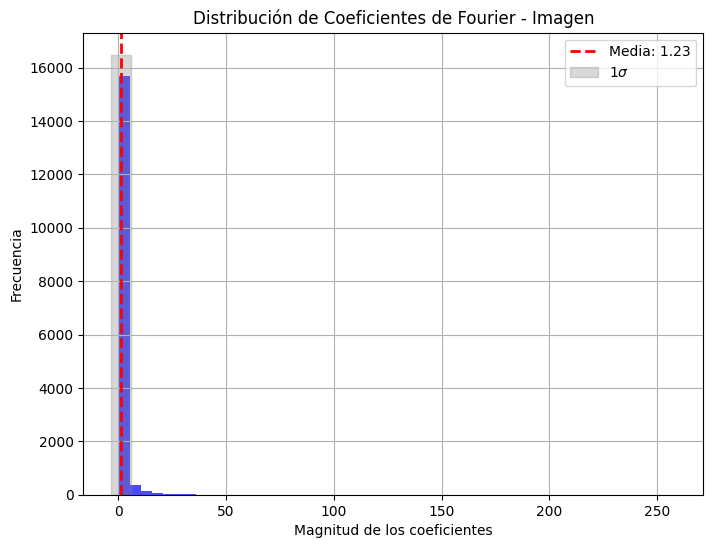

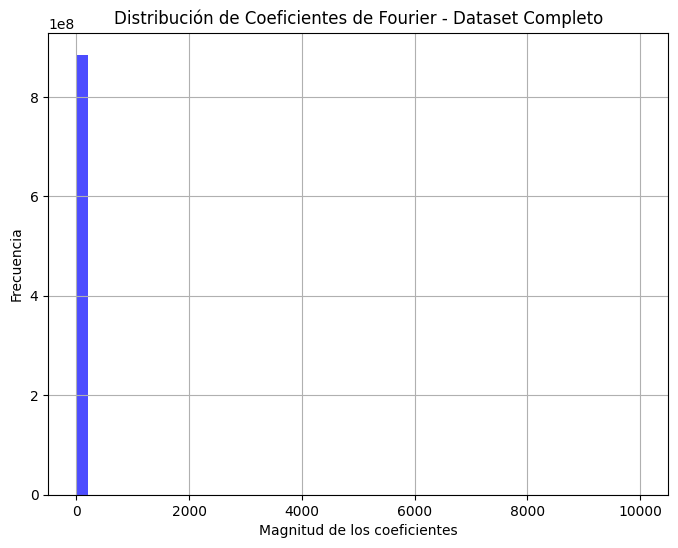

In [8]:
# Ejemplo de uso:
# Suponiendo que ya tienes un batch de imágenes de train_dataset
for X_batch, y_batch in train_dataset.take(1):
    image_example = y_batch[0, :, :, 0].numpy()  # Usar una imagen de ejemplo
    break

compare_image_vs_dataset(image_example, train_dataset)



Las siguientes dos celdas hacen procesos de estadistica sobre todo el dataset, correrlas puede implicar unos 15 minutos las dos funciones juntas.

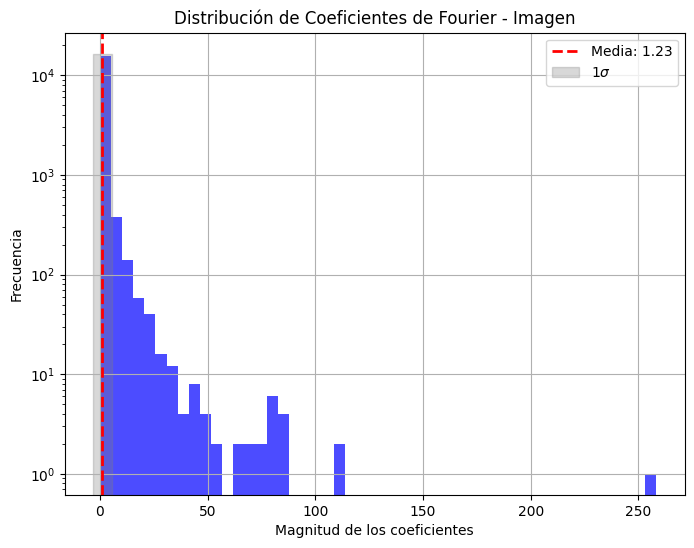

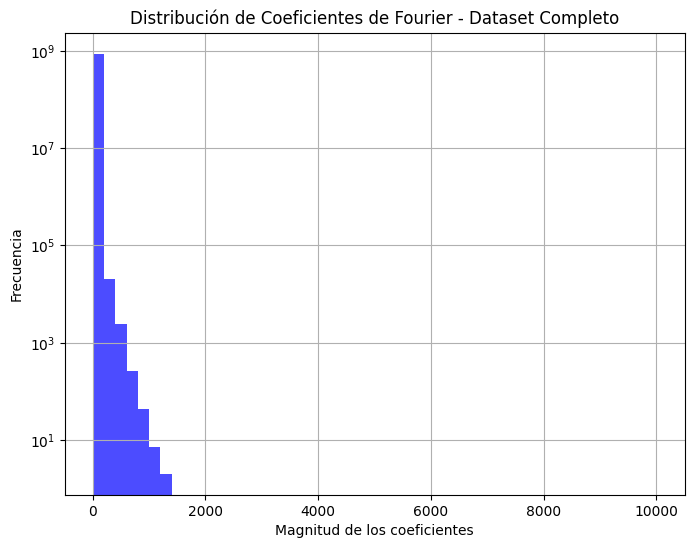

In [12]:
magnitude_image = fourier_transform_image(image_example)
fig = plot_fourier_distribution(magnitude_image, title="Distribución de Coeficientes de Fourier - Imagen")
plt.yscale("log")
plt.show(fig)

fig_dataset = plot_dataset_fourier_distribution_binned(train_dataset)
plt.yscale("log")
plt.show(fig_dataset)

# 8 minutos en correr con todo el dataset

In [17]:
mu, sigma = get_statistics_for_dataset_incremental(train_dataset)

# este metodo evita el alocar los multiples Gb de memoria
# corresponde a la media y la varianza de las magnitudes de los coeficientes de Fourier

In [27]:
print("Fourier")
print("mu:", mu)
print("sigma", sigma)


Fourier
mu: 1.2412409653425018
sigma 0.016873026549339535


Aplicando el threshold de $\mu \pm 1 \sigma$

Low frequency batch shape: (32, 128, 128, 1)
High frequency batch shape: (32, 128, 128, 1)
Reconstructed batch shape: (32, 128, 128, 1)


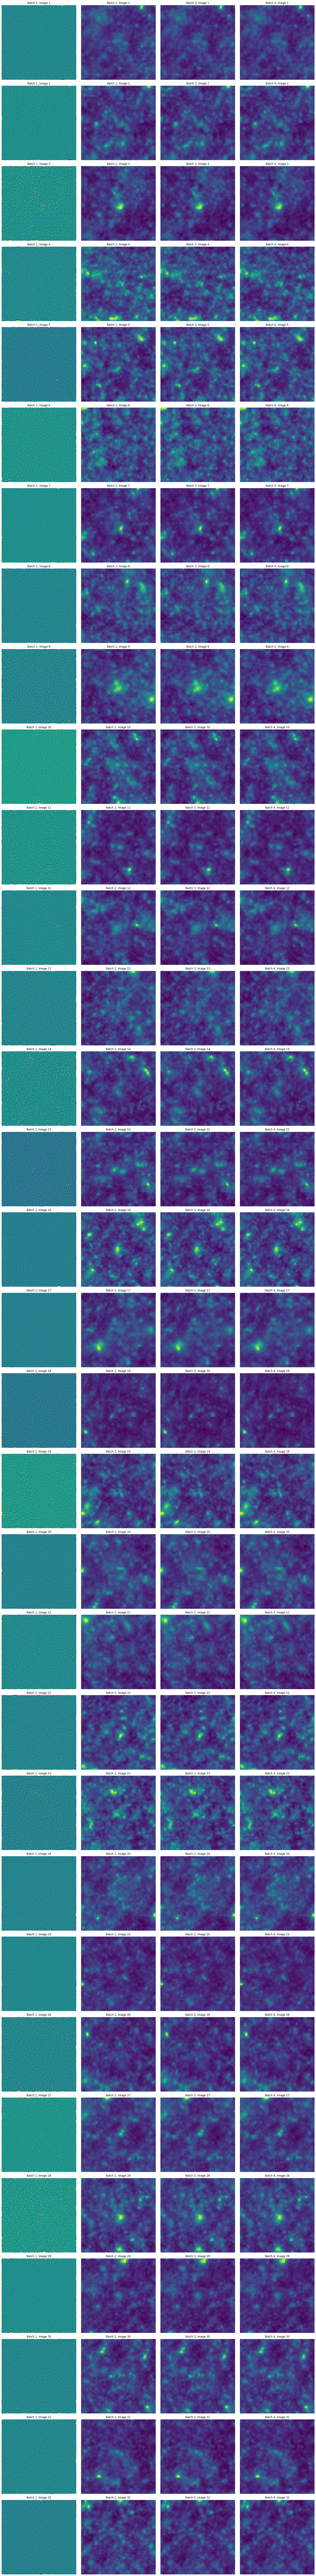

In [32]:
for X_batch, y_batch in train_dataset.take(1):
    # Procesar el batch para obtener las imágenes de baja y alta frecuencia
    low_freq_batch, high_freq_batch = process_batch(y_batch.numpy(), threshold= mu + 10*sigma)
    
    print("Low frequency batch shape:", low_freq_batch.shape)
    print("High frequency batch shape:", high_freq_batch.shape)
    
    # Verificar que la suma de ambas reconstruya la imagen original
    reconstructed_batch = low_freq_batch + high_freq_batch
    print("Reconstructed batch shape:", reconstructed_batch.shape)

from utils import plot_batch_list, plot_batch_dict

batch_list =  [low_freq_batch, high_freq_batch, reconstructed_batch, y_batch.numpy()]
plot_batch_list(batch_list, batch_size)

Utilizando filtros
El medir los coeficientes puede no resultar lo más util o intuitivo

In [33]:
def apply_lowpass_filter(f_transform, cutoff):
    """
    Aplica un filtro pasa bajas (low-pass) a la Transformada de Fourier.
    
    Parámetros:
        f_transform (numpy array): Transformada de Fourier de la imagen.
        cutoff (float): Frecuencia de corte para el filtro (entre 0 y 1, relativa al tamaño de la imagen).
        
    Retorna:
        lowpass_filtered (numpy array): Transformada de Fourier filtrada con pasa bajas.
    """
    # Crear una malla de coordenadas para definir las distancias
    rows, cols = f_transform.shape
    crow, ccol = rows // 2, cols // 2  # Centro de la imagen

    # Crear una máscara pasa bajas (con 1 en el centro y 0 en los bordes)
    mask = np.zeros((rows, cols), dtype=np.float32)
    radius = cutoff * min(crow, ccol)  # Radio de corte basado en la frecuencia relativa
    for i in range(rows):
        for j in range(cols):
            if np.sqrt((i - crow) ** 2 + (j - ccol) ** 2) <= radius:
                mask[i, j] = 1
    
    # Aplicar la máscara a la Transformada de Fourier
    lowpass_filtered = f_transform * mask
    return lowpass_filtered

def apply_highpass_filter(f_transform, cutoff):
    """
    Aplica un filtro pasa altas (high-pass) a la Transformada de Fourier.
    
    Parámetros:
        f_transform (numpy array): Transformada de Fourier de la imagen.
        cutoff (float): Frecuencia de corte para el filtro (entre 0 y 1, relativa al tamaño de la imagen).
        
    Retorna:
        highpass_filtered (numpy array): Transformada de Fourier filtrada con pasa altas.
    """
    # Crear una malla de coordenadas para definir las distancias
    rows, cols = f_transform.shape
    crow, ccol = rows // 2, cols // 2  # Centro de la imagen

    # Crear una máscara pasa altas (con 0 en el centro y 1 en los bordes)
    mask = np.ones((rows, cols), dtype=np.float32)
    radius = cutoff * min(crow, ccol)  # Radio de corte basado en la frecuencia relativa
    for i in range(rows):
        for j in range(cols):
            if np.sqrt((i - crow) ** 2 + (j - ccol) ** 2) <= radius:
                mask[i, j] = 0
    
    # Aplicar la máscara a la Transformada de Fourier
    highpass_filtered = f_transform * mask
    return highpass_filtered

def process_image_with_filters(image, cutoff=0.1):
    """
    Procesa una imagen para separar las componentes de baja y alta frecuencia usando filtros pasa bajas y pasa altas.
    
    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
        cutoff (float): Frecuencia de corte para los filtros (entre 0 y 1, relativa al tamaño de la imagen).
        
    Retorna:
        low_freq_image (numpy array): Imagen de baja frecuencia.
        high_freq_image (numpy array): Imagen de alta frecuencia.
    """
    # Aplicar la Transformada de Fourier
    f_transform = apply_fourier_transform(image)
    
    # Aplicar filtro pasa bajas
    low_freq_transform = apply_lowpass_filter(f_transform, cutoff)
    
    # Aplicar filtro pasa altas
    high_freq_transform = apply_highpass_filter(f_transform, cutoff)
    
    # Reconstruir las imágenes de baja y alta frecuencia
    low_freq_image = inverse_fourier_transform(low_freq_transform)
    high_freq_image = inverse_fourier_transform(high_freq_transform)
    
    return low_freq_image, high_freq_image

In [51]:
mu

1.2412409653425018

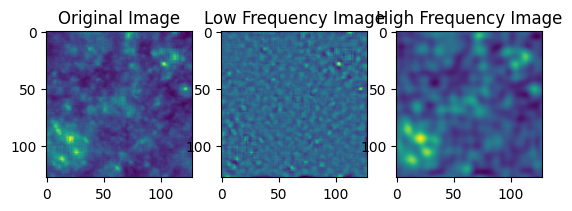

In [52]:
# Procesar una imagen con filtros pasa bajas y pasa altas

low_freq_image, high_freq_image = process_image_with_filters(image_example, cutoff=mu)

# Visualizar las imágenes de baja y alta frecuencia
plt.subplot(1, 3, 1)
plt.imshow(image_example)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(low_freq_image)
plt.title('Low Frequency Image')

plt.subplot(1, 3, 3)
plt.imshow(high_freq_image)
plt.title('High Frequency Image')

plt.show()


Filtro de Hamming

In [59]:
import numpy as np

def apply_fourier_transform(image):
    """
    Aplica la Transformada de Fourier bidimensional a una imagen.
    
    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
        
    Retorna:
        f_transform_shifted (numpy array): Transformada de Fourier desplazada con fftshift.
    """
    f_transform = np.fft.fft2(image)
    return np.fft.fftshift(f_transform)  # Mover las frecuencias bajas al centro

def inverse_fourier_transform(f_transform_shifted):
    """
    Aplica la Transformada Inversa de Fourier a una imagen.
    
    Parámetros:
        f_transform_shifted (numpy array): Transformada de Fourier desplazada.
        
    Retorna:
        image_reconstructed (numpy array): Imagen reconstruida a partir de la transformada de Fourier.
    """
    f_transform = np.fft.ifftshift(f_transform_shifted)  # Deshacer el shift
    return np.fft.ifft2(f_transform).real  # Obtener la imagen real reconstruida

def apply_hamming_filter(f_transform):
    """
    Aplica un filtro de ventana de Hamming a la Transformada de Fourier desplazada.
    
    Parámetros:
        f_transform (numpy array): Transformada de Fourier desplazada.
    
    Retorna:
        hamming_filtered (numpy array): Transformada de Fourier filtrada con la ventana de Hamming.
    """
    rows, cols = f_transform.shape
    hamming_window = np.hamming(rows)[:, None] * np.hamming(cols)[None, :]
    
    # Aplicar la ventana de Hamming a la Transformada de Fourier
    hamming_filtered = f_transform * hamming_window
    return hamming_filtered

def process_image_with_hamming(image):
    """
    Procesa una imagen aplicando un filtro de ventana de Hamming a la Transformada de Fourier.
    
    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
    
    Retorna:
        filtered_image (numpy array): Imagen filtrada utilizando la ventana de Hamming.
    """
    # Aplicar la Transformada de Fourier con fftshift
    f_transform_shifted = apply_fourier_transform(image)
    
    # Aplicar el filtro de Hamming a la Transformada de Fourier
    hamming_filtered_transform = apply_hamming_filter(f_transform_shifted)
    
    # Reconstruir la imagen filtrada
    filtered_image = inverse_fourier_transform(hamming_filtered_transform)
    
    return filtered_image

def apply_gaussian_filter(f_transform, sigma=10):
    """
    Aplica un filtro gaussiano en el dominio de Fourier para suavizar la imagen.
    
    Parámetros:
        f_transform (numpy array): Transformada de Fourier desplazada.
        sigma (float): Desviación estándar del filtro gaussiano.
        
    Retorna:
        gaussian_filtered (numpy array): Transformada de Fourier filtrada con el filtro gaussiano.
    """
    rows, cols = f_transform.shape
    crow, ccol = rows // 2, cols // 2  # Centro de la imagen

    # Crear un filtro gaussiano en el dominio de Fourier
    x = np.arange(0, cols)
    y = np.arange(0, rows)
    x, y = np.meshgrid(x, y)
    gaussian_filter = np.exp(-((x - ccol) ** 2 + (y - crow) ** 2) / (2 * sigma ** 2))

    # Aplicar el filtro gaussiano a la Transformada de Fourier
    gaussian_filtered = f_transform * gaussian_filter
    return gaussian_filtered

def process_image_with_gaussian(image, sigma=10):
    """
    Procesa una imagen aplicando un filtro gaussiano en el dominio de Fourier.
    
    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
        sigma (float): Desviación estándar del filtro gaussiano.
    
    Retorna:
        filtered_image (numpy array): Imagen filtrada utilizando el filtro gaussiano.
    """
    # Aplicar la Transformada de Fourier con fftshift
    f_transform_shifted = apply_fourier_transform(image)
    
    # Aplicar el filtro gaussiano
    gaussian_filtered_transform = apply_gaussian_filter(f_transform_shifted, sigma)
    
    # Reconstruir la imagen filtrada
    filtered_image = inverse_fourier_transform(gaussian_filtered_transform)
    
    return filtered_image


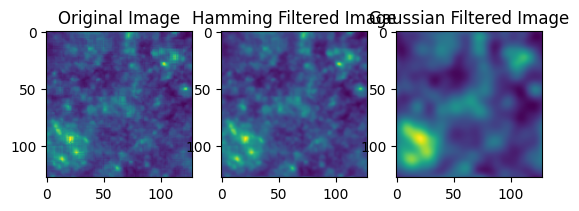

In [63]:
# Usar el filtro de Hamming
hamming_filtered_image = process_image_with_hamming(image_example)

# Usar el filtro gaussiano
gaussian_filtered_image = process_image_with_gaussian(image_example, sigma=5)

# Visualización de las imágenes filtradas
plt.subplot(1, 3, 1)
plt.imshow(image_example)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(hamming_filtered_image)
plt.title('Hamming Filtered Image')

plt.subplot(1, 3, 3)
plt.imshow(gaussian_filtered_image)
plt.title('Gaussian Filtered Image')

plt.show()


# Correr un IPCA

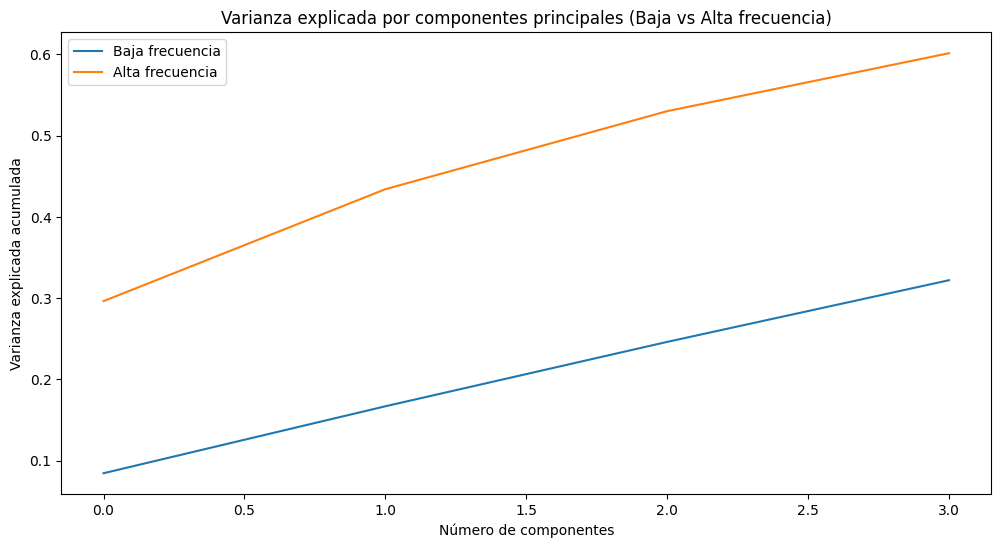

In [53]:

# Crear y aplicar IncrementalPCA para baja frecuencia
ipca_low = IncrementalPCA(n_components=n_components, batch_size=batch_size)

# Crear y aplicar IncrementalPCA para alta frecuencia
ipca_high = IncrementalPCA(n_components=n_components, batch_size=batch_size)

# Extraer imágenes del dataset en lotes y ajustar el IncrementalPCA
for X_batch, y_batch in train_dataset:
    # Obtener las imágenes de baja y alta frecuencia
    low_freq_batch, high_freq_batch = process_batch(y_batch.numpy(), threshold=mean_total + var_total)
    
    # Aplanar las imágenes y apilarlas para baja frecuencia
    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_freq_batch])
    
    # Aplanar las imágenes y apilarlas para alta frecuencia
    high_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in high_freq_batch])
    
    # Aplicar el ajuste incremental al IPCA para baja frecuencia
    ipca_low.partial_fit(low_freq_stack)
    
    # Aplicar el ajuste incremental al IPCA para alta frecuencia
    ipca_high.partial_fit(high_freq_stack)

# Calcular la varianza explicada acumulada para baja frecuencia
explained_variance_ratio_low = np.cumsum(ipca_low.explained_variance_ratio_)

# Calcular la varianza explicada acumulada para alta frecuencia
explained_variance_ratio_high = np.cumsum(ipca_high.explained_variance_ratio_)

# Imprimir la varianza explicada acumulada para baja frecuencia
for i, var in enumerate(explained_variance_ratio_low):
    if var >= 0.68:
        print(f"Se necesitan {i+1} componentes para explicar el 68% de la varianza en baja frecuencia.")
        break

# Imprimir la varianza explicada acumulada para alta frecuencia
for i, var in enumerate(explained_variance_ratio_high):
    if var >= 0.68:
        print(f"Se necesitan {i+1} componentes para explicar el 68% de la varianza en alta frecuencia.")
        break

# Graficar la varianza explicada acumulada
plt.figure(figsize=(12, 6))
plt.plot(explained_variance_ratio_low, label="Baja frecuencia")
plt.plot(explained_variance_ratio_high, label="Alta frecuencia")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Varianza explicada por componentes principales (Baja vs Alta frecuencia)")
plt.legend()
plt.show()


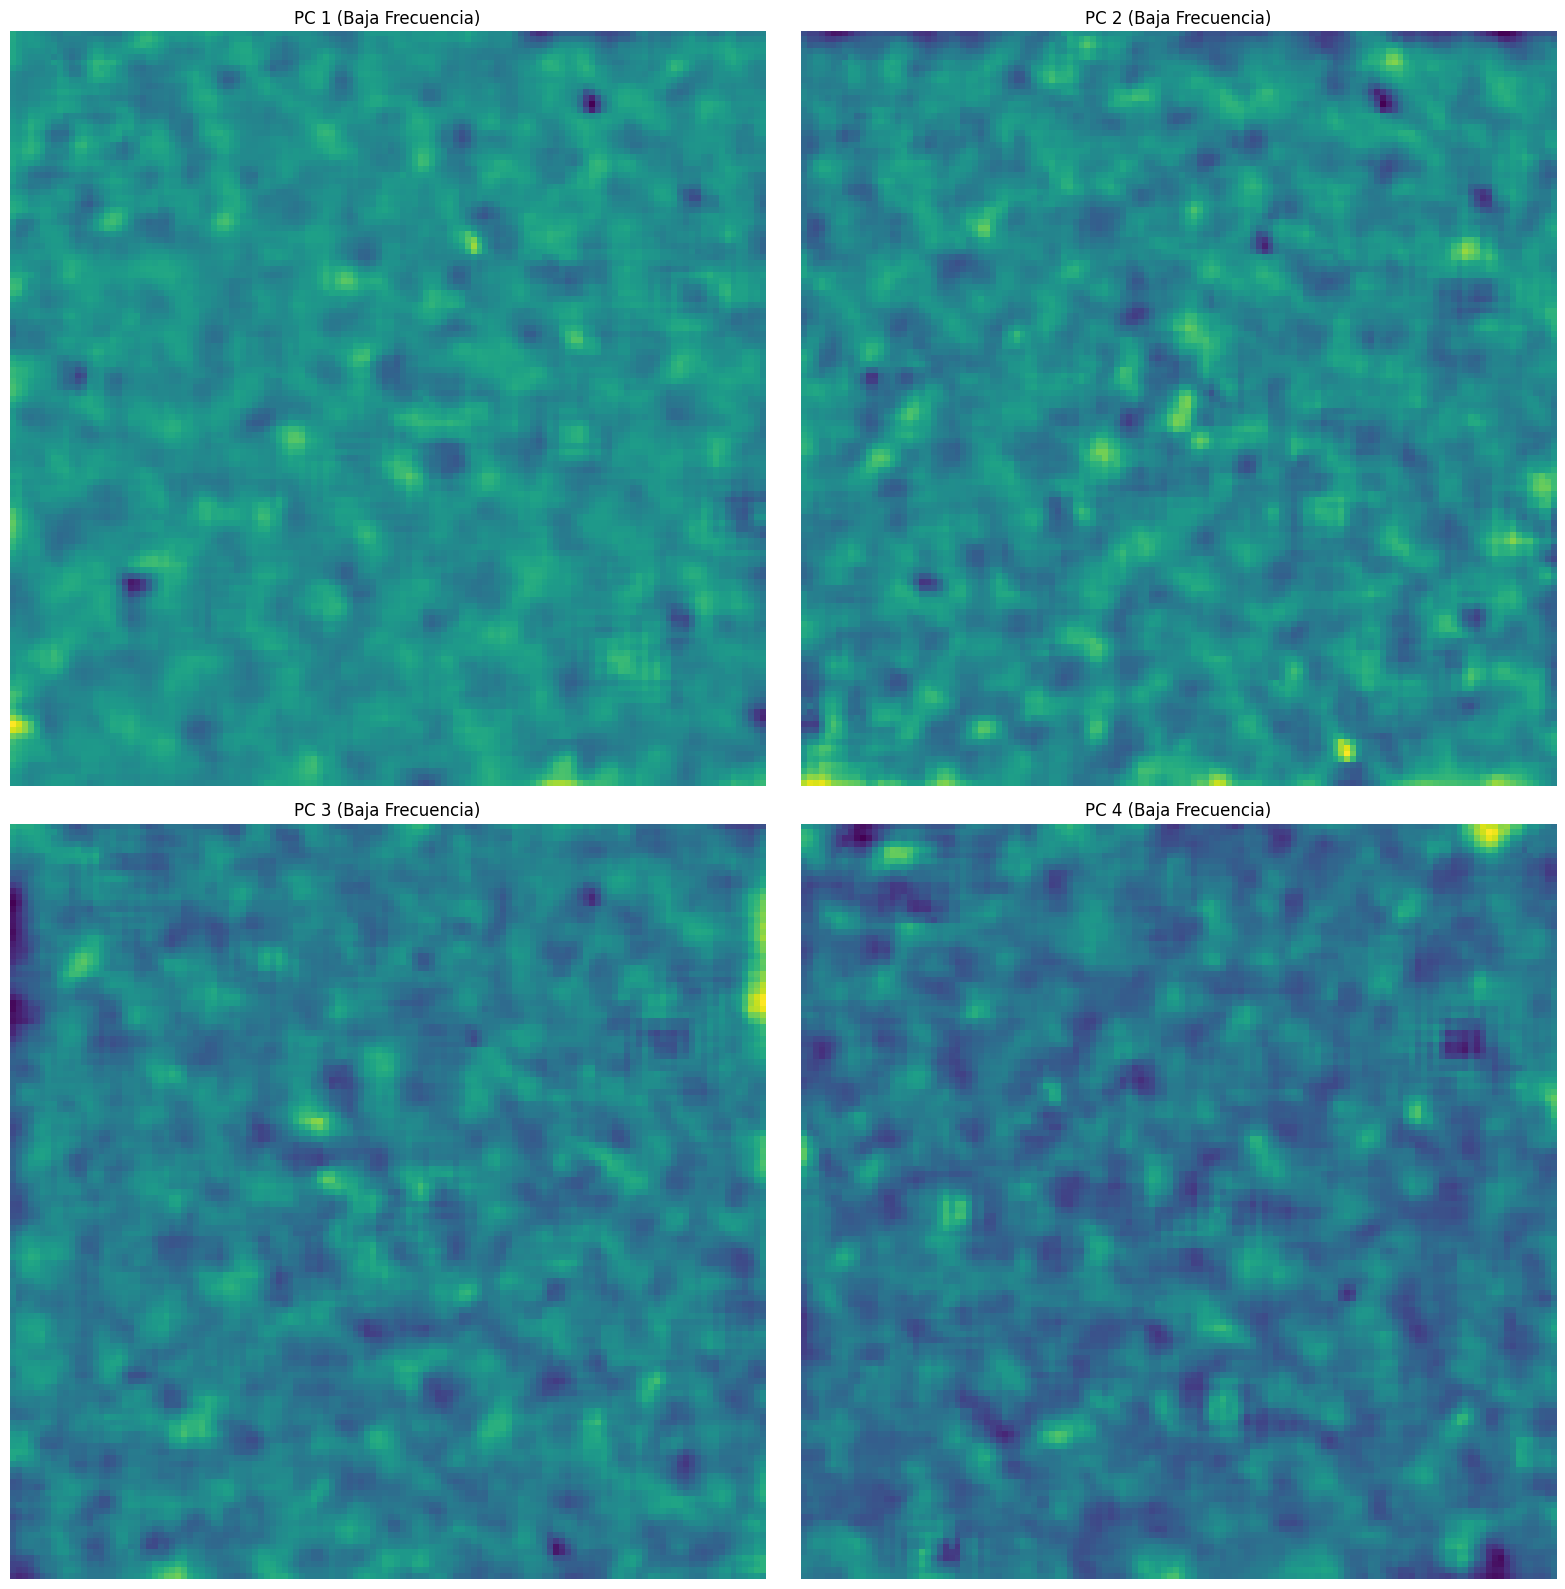

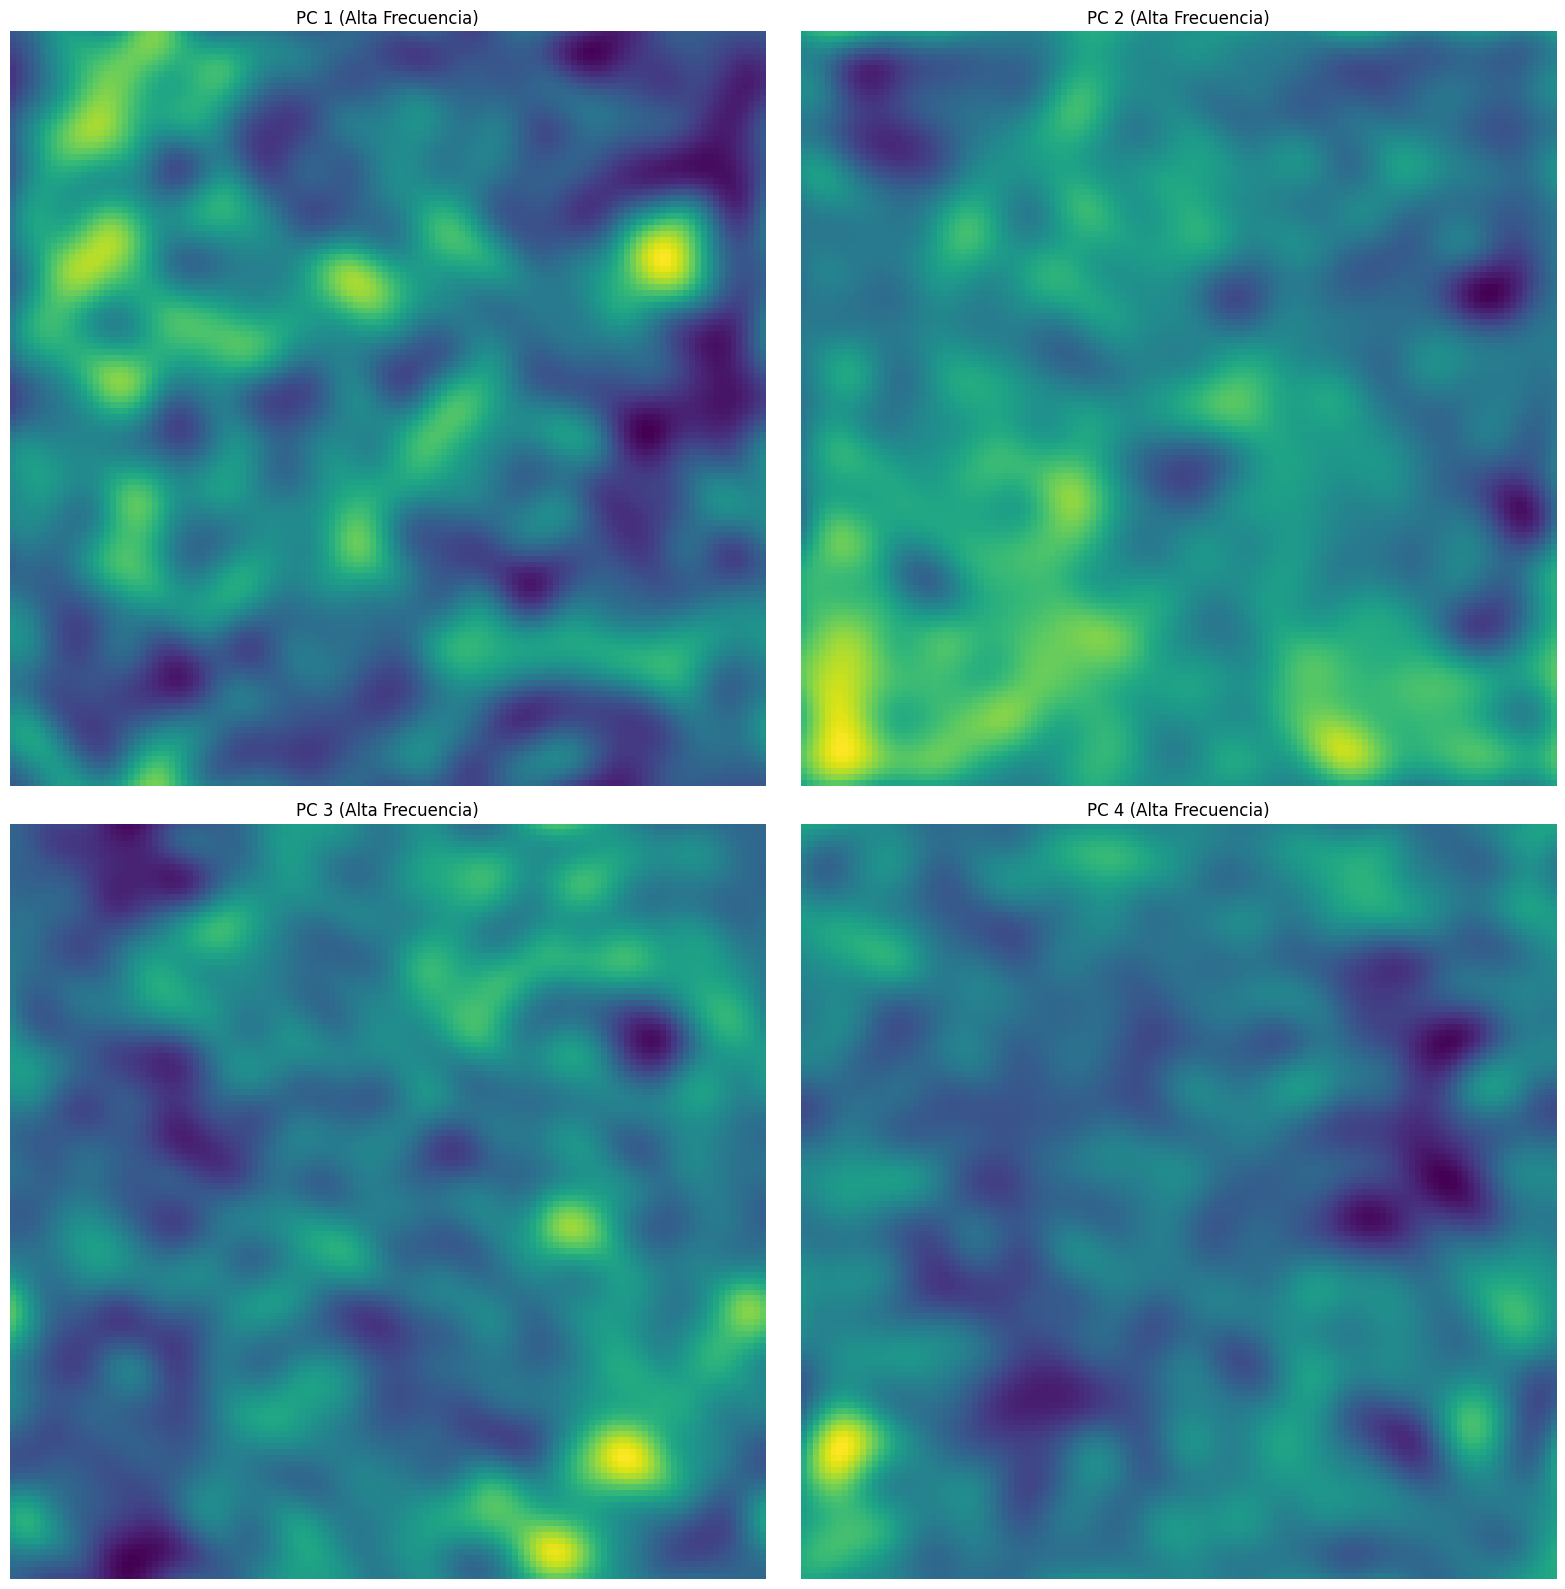

In [54]:
# Mostrar las primeras eigen-imágenes (componentes principales) para baja frecuencia
eigen_images_low = ipca_low.components_[:n_components].reshape((n_components, 128, 128))

# Mostrar las primeras eigen-imágenes (componentes principales) para alta frecuencia
eigen_images_high = ipca_high.components_[:n_components].reshape((n_components, 128, 128))

# Visualizar los primeros 64 componentes para baja frecuencia
fig, axes = plt.subplots(2, 2, figsize=(16, 16))  # 8 filas x 8 columnas para 64 imágenes
for i, ax in enumerate(axes.flat):
    ax.imshow(eigen_images_low[i], cmap='viridis')
    ax.set_title(f'PC {i+1} (Baja Frecuencia)')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Visualizar los primeros 64 componentes para alta frecuencia
fig, axes = plt.subplots(2, 2, figsize=(16, 16))  # 8 filas x 8 columnas para 64 imágenes
for i, ax in enumerate(axes.flat):
    ax.imshow(eigen_images_high[i], cmap='viridis')
    ax.set_title(f'PC {i+1} (Alta Frecuencia)')
    ax.axis('off')
plt.tight_layout()
plt.show()
